# Assignment 5: CudaVision
------
### Group Members:
__1.__ Saikat Roy

__2.__ Albert Gubaidullin

__Please note that detailed architectures and results are available in the output with *readable* messages. Important things are summarized either in the Headings or in the text block below the heading.__

## Import Dependencies
------

In [11]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torchsummary import summary

import zipfile
from PIL import Image

import matplotlib.pyplot as plt

import time
import os


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ResNet object loading and Summarizing
------
A pretrained resnet18 object is loaded from `torchvision.models`, moved to the GPU and summarized.

In [4]:
model = resnet18(pretrained=True)
model = model.cuda()
summary(model, (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Method for calculating accuracy
------
The `acc` method simply calculates the predictive accuracy of a model on the given dataloader. It returns the true labels, predicted labels and the accuracy as a float in the range [0,1]

In [0]:
def acc(dataloader):
    """
    Calculate accuracy of predictions from model for dataloader.
    :param dataloader: dataloader to evaluate
    :return:
    """
    acc = 0.0
    true_y = []
    pred_y = []
    total = 0.0
    model.eval()
    with torch.no_grad():
        for batch_id, (x, y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            #x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            acc += ((preds==y).sum().item())
            total+= y.size(0)

            true_y.extend(list(preds.view(-1).cpu().numpy()))
            pred_y.extend(list(y.view(-1).cpu().numpy()))

        acc/=total
    return true_y, pred_y, acc

## Method for training model in PyTorch
------
The `train` method takes a dataloader object and trains the model on it for the specified amount of iterations and returns the loss per iteration as a list. Also calculates the accuracy on the training validation set per epoch.

In [0]:
def train(train_dataloader, valid_dataloader, iters = 20, suppress_output=False,
         model_save_path = "best.pth"):
    """
    Trains the model on the given dataloader and returns the loss per epoch
    """
    loss_l = []
    train_acc_l = []
    valid_acc_l = []
    best_valid_acc = 0.0
    equiv_train_acc = 0.0
    for itr in range(iters):
        av_itr_loss = 0.0
        model.train()
        for batch_id, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x = x.cuda()
            y = y.cuda()
            #x = (x>0.5).float() * 1
            #x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            # print((z==1).sum())
            batch_loss = loss(preds, y)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/y.size(0))*batch_loss.item()
        loss_l.append(av_itr_loss)
        _, _, train_acc = acc(train_dataloader)
        _, _, valid_acc = acc(valid_dataloader)
        if not suppress_output:
          if itr%1 == 0 or itr==iters-1:
            print("Epoch {}: Loss={}, Training Accuracy:{}, Validation Accuracy:{}"
                  .format(itr, av_itr_loss, train_acc, valid_acc))
        train_acc_l.append(train_acc)
        valid_acc_l.append(valid_acc)
        if valid_acc>best_valid_acc:
          best_valid_acc = valid_acc
          equiv_train_acc = train_acc
          torch.save(model.state_dict(), model_save_path)
    
    model.load_state_dict(torch.load(model_save_path))
    
#   return loss_l, train_acc_l, valid_acc_l
    return loss_l, equiv_train_acc, best_valid_acc


## Initializing Hyperparameters and Datasets
-------
The base Datasets, the test Dataloaders and some training hyperparameters are initialized. The images are resized to `224x224` to allow for a ResNet18 to be used for classification.

In [59]:
batch_size = 8
n_itr = 10
lr = 0.0005
no_of_classes = 2
valid_samples_per_class = 50

# Object for loading custom dataset
class CustomDataset(Dataset):

    def __init__(self, folderpath, class_no, transform=None):
        """
        :param folderpath: Path to the Image Files. This path MUST have folders
        """
        super(CustomDataset, self).__init__()
        self.transform = transform
        self.class_no  = class_no
        for _, _, files in os.walk(folderpath, topdown=False):
            self._filenames_images = [os.path.join(folderpath,f) for f in files]

        #print(sorted(self._filenames_targets))
        #print(self._filenames_images)

    def __getitem__(self, index):
        #print(self._filenames_images[index], self._filenames_targets[index])
        _img = Image.open(self._filenames_images[index])#.resize((self.img_size, self.img_size))

        for t in self.transform:
          _img = t(_img)

        return _img, torch.tensor(self.class_no, dtype=torch.long)

    def __len__(self):
        return len(self._filenames_images)

# Download and unzip data      
if os.path.exists('/Colab_Data/robots'):
  print("Files exist. Not downloading.")
else:
  zip_ref = zipfile.ZipFile("drive/My Drive/Colab_Data/Data_Cudavision5.zip", 'r')
  zip_ref.extractall('/Colab_Data')
  zip_ref.close()


Files exist. Not downloading.


## Visualizing Images from our Custom Dataset
-------

Positive Images


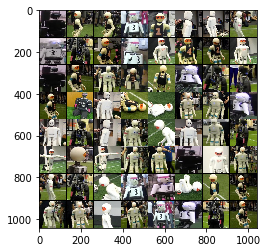

In [60]:
# Visualize data  
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

positive_set = CustomDataset(r"/Colab_Data/robots/", 0.0, [transforms.ToTensor()])
dataloader = DataLoader(positive_set, batch_size=1,shuffle=True,
                                                          drop_last=True)

t = None
for i, (x,y) in enumerate(dataloader):
  if i==64:
    break
  if t is None:
    t = x
  else:
    #print(t, x)
    t = torch.cat([t,x], 0)

print("Positive Images")
show(make_grid(t))


Negative images


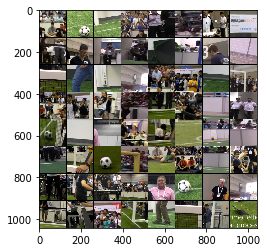

In [62]:
negative_set = CustomDataset(r"/Colab_Data/no_robot/", 1.0, [transforms.ToTensor()])
dataloader = DataLoader(negative_set, batch_size=1,shuffle=True,
                                                            drop_last=True)
t = None
for i, (x,y) in enumerate(dataloader):
  if i==64:
    break
  if t is None:
    t = x
  else:
    #print(t, x)
    t = torch.cat([t,x], 0)

print("Negative images")
show(make_grid(t))

## Creating the dataset to be used for Training and Validation
------
The robot and non-robot data are given a label of 0 and 1 respectively. The 50 samples each from the robot and non-robot data are used to create a validation dataset.

In [63]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform_list = [#transforms.Scale(256),
                  transforms.ToTensor(),
                  normalize]
    
positive_set = CustomDataset(r"/Colab_Data/robots/", 0.0, transform_list)
negative_set = CustomDataset(r"/Colab_Data/no_robot/", 1.0, transform_list)

print("Files with Robots: {}, Non-robots: {}".format(len(positive_set),
                                                     len(negative_set)))
p_size = len(positive_set)
n_size = len(negative_set)

positive_set_train, positive_set_valid = random_split(positive_set, 
                                                [p_size-valid_samples_per_class,
                                                 valid_samples_per_class])
negative_set_train, negative_set_valid = random_split(negative_set, 
                                                [n_size-valid_samples_per_class,
                                                 valid_samples_per_class])


train_dataset = ConcatDataset([positive_set_train, negative_set_train])
valid_dataset = ConcatDataset([positive_set_valid, negative_set_valid])

print("Size of training set:{}, validation set: {}".
              format(len(train_dataset), len(valid_dataset)))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,
                                                                  drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,shuffle=True)

Files with Robots: 1197, Non-robots: 182
Size of training set:1279, validation set: 100


## Training (fine tuning) the model
------
The Resnet18 model is finetuned using the custom Robot dataset.

In [67]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
loss_type = "Cross_Entropy"
optim = torch.optim.Adam

t1 = time.time()
model.fc = nn.Linear(512, no_of_classes) # Redefining output layer for binary problem
model.cuda()

model.train()
# The CE Loss is weighed with the amount of positive and negative classes
# since the dataset is not balanced
loss = nn.CrossEntropyLoss(torch.tensor([p_size-valid_samples_per_class,
                                        n_size-valid_samples_per_class],
                                        dtype=torch.float).cuda())
optimizer = optim(model.parameters(), lr=lr)
loss_list, train_acc, valid_acc = train(train_dataloader, valid_dataloader, 
                                        iters=n_itr, model_save_path="model1.pth")
t2 = time.time()

_,_, test_acc = acc(valid_dataloader)
print("Time to converge: {} sec".format(t2-t1))
print("Best train accuracy={}, valid accuracy={} (based on the later)".
                                          format(train_acc, valid_acc))
print("Test accuracy on best model={}".format(test_acc))

Epoch 0: Loss=0.22404194748321515, Training Accuracy:0.9827044025157232, Validation Accuracy:0.82
Epoch 1: Loss=0.22740055309259333, Training Accuracy:0.9968553459119497, Validation Accuracy:0.86
Epoch 2: Loss=0.038209775894756604, Training Accuracy:1.0, Validation Accuracy:0.95
Epoch 3: Loss=0.0122130187384073, Training Accuracy:1.0, Validation Accuracy:0.96
Epoch 4: Loss=0.0027923120589434802, Training Accuracy:1.0, Validation Accuracy:0.96
Epoch 5: Loss=0.0013213230496376127, Training Accuracy:1.0, Validation Accuracy:0.94
Epoch 6: Loss=0.0020775786250339934, Training Accuracy:1.0, Validation Accuracy:0.96
Epoch 7: Loss=0.0006246225778312464, Training Accuracy:1.0, Validation Accuracy:0.95
Epoch 8: Loss=0.0005208012865125511, Training Accuracy:1.0, Validation Accuracy:0.94
Epoch 9: Loss=0.0006523597712941864, Training Accuracy:1.0, Validation Accuracy:0.94
Time to converge: 57.68858194351196 sec
Best train accuracy=1.0, valid accuracy=0.96 (based on the later)
Test accuracy on best 